In [1]:
import sympy #symbolic python library
from sympy.utilities.lambdify import lambdify #translate symbolic sympy to python commands 
from sympy import init_printing
init_printing(use_latex=True) 

import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.misc.optimizers import adam
from functools import reduce

from reusable_functions import init_random_params, neural_net_predict, modded_basinhopping

In [2]:
#Problem Setup: 
#Make sure the exact solution has BCs that are compatible with G and D below. 
#Make sure the residual and forcing functions correspond to your ODE.
x=sympy.symbols('x')

u=sympy.cos(x)
uprime=u.diff(x)
udprime=uprime.diff(x)
forcing_fn_symbolic=udprime+u
#udprime #uncomment for latex print udprime expression

forcing_fn = lambdify((x), forcing_fn_symbolic) #transform symbolic expression into python function
u_exact=lambdify((x), u)
layer_sizes=[1,10,10,1]
nx=100
G=lambda x:1. #to satisfy BCs
D=lambda x:x**2 #distance function

x_space = np.linspace(0, 10, nx)#Problem Setup: 
#Make sure the residual and forcing functions correspond to your ODE.

forcing_fn = lambda x: 0.
layer_sizes=[1,10,10,1]
nx=100
G=lambda x:x
def u(params, x):
    return G(x)+D(x)*neural_net_predict(params, x)


du=grad(u,1)
du2=grad(du,1)

def resid(params, x): 
    return np.square(du2(params,x)+u(params,x)-forcing_fn(x))

In [3]:
def resid_batch(params, x_batch):
    resid_temp=list(map(lambda x: resid(params, x)**2, x_batch))
    resid_sum=reduce(lambda x,y:x+y, resid_temp)
    return resid_sum/len(x_batch)  
def loss_function(params):
    return resid_batch(params, x_space)

loss_grad=grad(loss_function)

x0=init_random_params(1, layer_sizes)
optimized_params, fun=modded_basinhopping(loss_function, loss_grad,x0, num_iter=0, max_bfgs_iter=100)

/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Start basinhopping.Current func val:[5.46390921e+08]
Basinhopping fun: f(x) = [0.00138558]
Call fun itself: [0.00138558]


Text(0.5, 1.0, 'phase portrait')

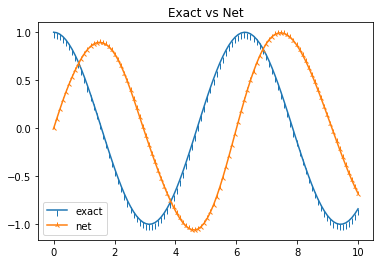

<Figure size 432x288 with 0 Axes>

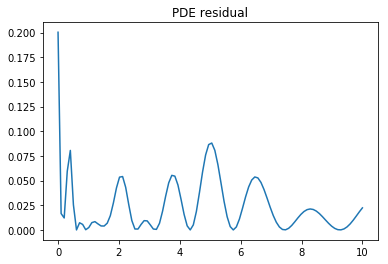

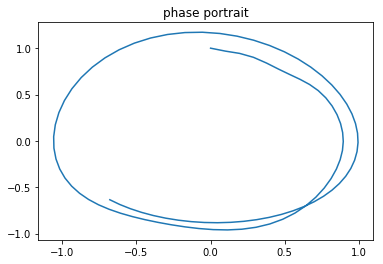

In [4]:
plt.figure
plt.clf()
ax=plt.gca()

sln = np.zeros(nx)

for i,x in enumerate(x_space):
    sln[i]=u_exact(x)

plt.plot(x_space, sln,label='exact', marker=3)

for i,x in enumerate(x_space):
    sln[i]=u(optimized_params, x)

plt.plot(x_space, sln, label='net', marker='2')
plt.title("Exact vs Net")
ax.legend()

plt.figure()
err=np.zeros(np.size(x_space))
for i, x in enumerate(x_space):
    err[i]=u(optimized_params, x)-u_exact(x)
    
plt.figure()
pde_err=np.zeros(x_space.shape)
for i, x in enumerate(x_space):
    pde_err[i]=resid(optimized_params, x)

plt.plot(x_space, pde_err, label='error')
plt.title('PDE residual')

pos=np.zeros(x_space.shape)
vel=np.zeros(x_space.shape)

plt.figure()
for i, x in enumerate(x_space):
    pos[i]=u(optimized_params, x)
    vel[i]=du(optimized_params, x)
plt.plot(pos, vel, label='phase plot')
plt.title('phase portrait')


